In [31]:
# You should be able to just run the whole script to align
# Just run all cells
#this
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import fsolve
sys.path.append('../../')
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
# from geecs_python_api.controls.experiment.experiment import Experiment



In [131]:
# This cell for control room setup
# DO NOT RUN

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("ControlRoom")

# set up the python objects for the geecs devices to be used in optimization
camera1 = GeecsDevice('CAM-CR-Beampointing')
camera1.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
time.sleep(0.1)
print(camera1.state)
exposure = camera1.get('exposure')
print(f"Camera exposure is {exposure}")

target1x = camera1.get('Target.X')
target1y = camera1.get('Target.Y')
target2x = camera1.get('Target2.X')
target2y = camera1.get('Target2.Y')
print(f"Target 1 coordinates: ({int(target1x)}, {int(target1y)})")
print(f"Target 2 coordinates: ({int(target2x)}, {int(target2y)})")

centroidx = camera1.get('Centroidx')
print(centroidx)
print(camera1.state)

# camera2 = GeecsDevice('CAM-CR-Beampointing2')
# camera2.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
# time.sleep(0.1)
# print(camera2.state)
# exposure = camera2.get('exposure')
# print(f"Camera exposure is {exposure}")

# target1x = camera2.get('Target.X')
# target1y = camera2.get('Target.Y')
# target2x = camera2.get('Target2.X')
# target2y = camera2.get('Target2.Y')
# print(f"Target 1 coordinates: ({int(target1x)}, {int(target1y)})")
# print(f"Target 2 coordinates: ({int(target2x)}, {int(target2y)})")

# centroidx = camera2.get('Centroidx')
# print(centroidx)
# print(camera2.state)

# picos = GeecsDevice('MCD-CR-Beampointing-PICOS')
# picos.subscribe_var_values(['Position.Axis 1', 'Position.Axis 2', 'Position.Axis 3', 'Position.Axis 4'])
# """For picos: beam path looks like this:
#     |      |
#     |      |
#     |      |
#     |      |
#    \|______|/
#     \      /
#    1,2     3,4 

# 1, 3 are x-dir
# 2, 4 are y-dir

# increasing pico position means increasing x, decreasing y
# """

# print("Initial pico motor positions:")
# print(f"1: {picos.get('Position.Axis 1')}")
# print(f"2: {picos.get('Position.Axis 2')}")
# print(f"3: {picos.get('Position.Axis 3')}")
# print(f"4: {picos.get('Position.Axis 4')}")
# print(picos.state)

conex = GeecsDevice('STAGE-PL1-HolyMirror')
conex.subscribe_var_values(['position'])
print("Initial conex position")
print(f"1: {conex.get('position')}")

#this

# Negative values mean increasing mcd position decreases camera pixel value
# Camera 1 for CR
steps_per_pixel_cr1 = 26.31
steps_per_pixel_cr2 = -29.41
steps_per_pixel_cr3 = 12.04
steps_per_pixel_cr4 = -16.12

# Camera 2 for Control room (nearer camera)
steps_per_pixel_cr1 = -30.30
steps_per_pixel_cr2 = -35.71
steps_per_pixel_cr3 = -17.54
steps_per_pixel_cr4 = -22.72

steps_per_pixel_3 = 6.172
steps_per_pixel_4 = 8.70
steps_per_pixel_hex_x = 7.19e-4
steps_per_pixel_hex_y = -6.29e-4
      
steps_per_pixel_conex1 = 0.00014694937

# CR[1-4] are for testing
mcd_dict = {
#     'CR1': {
#         'device': picos, 
#         'name': 'Position.Axis 1', 
#         'alias': 'Position.Axis 1', 
#         'calib': steps_per_pixel_cr1,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'x',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#        },
#     'CR2': {
#         'device': picos, 
#         'name': 'Position.Axis 2', 
#         'alias': 'Position.Axis 2', 
#         'calib': steps_per_pixel_cr2, 
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'y',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#         },
#     'CR3': {
#         'device': picos, 
#         'name': 'Position.Axis 3', 
#         'alias': 'Position.Axis 3', 
#         'calib': steps_per_pixel_cr3,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'x',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#        },
#     'CR4': {
#         'device': picos, 
#         'name': 'Position.Axis 4', 
#         'alias': 'Position.Axis 4', 
#         'calib': steps_per_pixel_cr4,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'y',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#         },
    'conex1': {
        'device': conex, 
        'name': 'position', 
        'alias': 'position', 
        'calib': steps_per_pixel_conex1,
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': 0, # Software limits for beampointing
        'max': 5,
    }
}

SHOTS_TO_AVG = 1
TIME_BETWEEN_SHOTS = 0.1

CONEX_VEL = 0.5
CONEX_ACCEL = 4
CONEX_HYSTERESIS_SIZE = 0.03

{'fresh': True, 'shot number': None}
Camera exposure is 0.0005
Target 1 coordinates: (200, 309)
Target 2 coordinates: (542, 319)
333.814911
{'fresh': True, 'shot number': 0, 'exposure': 0.0005, 'Device Status': 'Initialized', '': 333.814911, 'device error': '', 'device preset': '', 'Target.X': 200.0, 'Target.Y': 309.0, 'Target2.X': 542.0, 'Target2.Y': 319.0}
Initial conex position
1: 3.141761


In [ ]:
#this

# This cell for BELLA LPMode setup
GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Bella")
camera = GeecsDevice('CAM-PL1-LPMode')
camera.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
exposure = camera.get('exposure')
print(f"Camera exposure is {exposure}")
print(camera.state)

picos = GeecsDevice('MCD-PL1-picosOFI2')
picos.subscribe_var_values(['holy mirror horizontal', 'holy mirror vertical'])
print("Initial pico motor positions:")
print(f"3: {picos.get('Position.Axis 3')}") # holy mirror horizontal
print(f"4: {picos.get('Position.Axis 4')}") # holy mirror vertical
print(picos.state)

hexapod = GeecsDevice('HEX-PL1-2')
hexapod.subscribe_var_values(['ypos', 'zpos']) # ypos for x, zpos for y
print("Initial hexapod positions:")
print(f"ypos: {hexapod.get('ypos')}") # axicon horizontal
print(f"zpos: {hexapod.get('zpos')}") # axicon vertical
print(hexapod.state)

stage = GeecsDevice('STAGE-PL1-LPmodeLong')
stage.subscribe_var_values(['position'])
print("Initial stage positions:")
print(f"ypos: {stage.get('position')}") # stage pos
print(stage.state)

In [ ]:
#this

steps_per_pixel_3 = 6.172
steps_per_pixel_4 = 8.70
steps_per_pixel_hex_x = 7.19e-4
steps_per_pixel_hex_y = -6.29e-4

mcd_dict = {
    3: { # Holy Mirror pico
        'device': picos, 
        'name': 'Position.Axis 3', 
        'alias': 'holy mirror horizontal', 
        'calib': steps_per_pixel_3, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': picos.get('Position.Axis 3') - 5000, # Software limits for beampointing
        'max': picos.get('Position.Axis 3') + 5000, # You can change the +- to be larger if the beam doesn't fit
       },
    4: { # Holy mirror pico
        'device': picos, 
        'name': 'Position.Axis 4', 
        'alias': 'holy mirror vertical', 
        'calib': steps_per_pixel_4, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'y', 
        'min': picos.get('Position.Axis 4') - 5000,
        'max': picos.get('Position.Axis 4') + 5000,
       },
    'hex_x': {
        'device': hexapod, 
        'name': 'ypos', 
        'alias': 'ypos', 
        'calib': steps_per_pixel_hex_x, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': hexapod.get('ypos') - 0.4,
        'max': hexapod.get('ypos') + 0.4,
        },
    'hex_y': {
        'device': hexapod, 
        'name': 'zpos', 
        'alias': 'zpos', 
        'calib': steps_per_pixel_hex_y, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'y',
        'min': hexapod.get('zpos') - 0.4,
        'max': hexapod.get('zpos') + 0.4,
        },
}

In [5]:
#this
# Hyperparameters
SHOTS_TO_AVG = 3
TIME_BETWEEN_SHOTS = 2 # seconds

In [144]:
def set_with_limit(mcd, value, min_val=None, max_val=None):
    """
    Set a parameter with software limits, default is no limit
    This is a blocking function since we are setting
    
    mcd: device dictionary in mcd_dict
    value: value to set to
    min_val, max_val: you can temporarily override the software limits by specifying
    a non-null value
    
    return: actual value set
    """
    if not min_val:
        min_val = mcd['min']
    if not max_val:
        max_val = mcd['max']
        
    if min_val > max_val:
        raise Exception('min_val must be smaller than max_val')
        
    mcd['device'].set(mcd['name'], max(min_val, min(max_val, value)))
    return max(min_val, min(max_val, value))

In [178]:
# Hysteresis fix for conex
def conex_move_time(move_size, vel, accel):
    """
    Estimates the time for a conex move
    """
    t_accel = vel/accel
    t_vel = (move_size / 2 - 0.5 * accel * t_accel**2) / vel
    return (t_vel + t_accel) * 2 + 1.5 # Arbitrary extra time for move = 2

def conex_move_hysteresis(conex_name, new_pos, eps):
    """
    Moves a conex motor with hysteresis compensation in the positive direction
    conex_name: name of the conex device in the mcd_dict
    new_pos: position to move to
    eps: size of hysteresis compensation
    """
    conex = mcd_dict[conex_name]
    cur_pos = conex['device'].get(conex['name'])
    print(f"new pos: {new_pos}, cur_pos: {cur_pos}")
    set_with_limit(conex, new_pos)
    if new_pos > cur_pos: # moving in + direction
        print("forward", conex_move_time(new_pos + eps - cur_pos, CONEX_VEL, CONEX_ACCEL))
        time.sleep(conex_move_time(new_pos + eps - cur_pos, CONEX_VEL, CONEX_ACCEL))
        time.sleep(0.5) # wait a bit for the motor to turn around
        print("backwards", conex_move_time(eps, CONEX_VEL, CONEX_ACCEL))
        time.sleep(conex_move_time(eps, CONEX_VEL, CONEX_ACCEL))
    else: # moving in - direction
        time.sleep(conex_move_time(cur_pos - new_pos, CONEX_VEL, CONEX_ACCEL))

In [147]:
#this
# Beam pointing onto target
def obj_func(targetx, targety, beamx, beamy):
    return (targetx - beamx)**2 + (targety - beamy)**2

def move_random(pico_num, picos, dmin, dmax):
    """
    pico_num: an index for mcd_dict
    picos: GEECS picos object
    moves the pico between [dmin, dmax] randomly from its original position
    """
    picomotor = mcd_dict[pico_num]
    new_pos = picos.state[picomotor['name']] + random.randint(dmin, dmax)
    print(f"moving motor {pico_num} to position {new_pos}")
    picos.set(picomotor['name'], int(picos.state[picomotor['name']] + random.randint(dmin, dmax)))
    return

def get_centroid(camera, num_shots, time_between_shots):
    """
    Returns (x,y) of centroid of beam
    """
    centroidx = []
    centroidy = []
    # Average over SHOTS_TO_AVG shots
    for i in range(num_shots):
        # While loops since sometimes the camera doesn't send back a value for centroid
        centroidx1, centroidy1 = None, None
        while not isinstance(centroidx1, float):
            centroidx1 = camera.get('Centroidx')
#             print(centroidx1)
        centroidx.append(centroidx1)
        while not isinstance(centroidy1, float):
            centroidy1 = camera.get('Centroidy')
        centroidy.append(centroidy1)
        time.sleep(time_between_shots)

    centroidx = np.mean(np.array(centroidx))
    centroidy = np.mean(np.array(centroidy))
    return centroidx, centroidy

def move_onto_target(camera, obj_target, opt_rate, pico1, pico2, target, fit='linear', 
                     fine_thresh=10, hexapod_flag=True, verbose=True):
    """
    Moves a beam onto a target with pico1 and pico2
    
    camera: GEECS camera object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    pico1, pico2: choose 2 picos, they must be one in the x direction and one
    in the y direction, these should be keys in the mcd_dict
    target: an integer 1 or 2, this is which target we are pointing at
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside mcd_dict)
    hexapod_flag: True if aligning hexapods, False if aligning picos
    (This is because hexapods take floats as inputs, and picos take ints as inputs)
    
    returns: iterations, obj_func()
    """
    if hexapod_flag:
        print("Moving a hexapod")
    else:
        print("Moving pico motors")
    
    # Helper function to calculate objective function
    def obj():
        centroidx, centroidy = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
            
        if target == 1:
            return obj_func(camera.state['Target.X'], camera.state['Target.Y'], 
                            centroidx, centroidy)
        elif target == 2:
            return obj_func(camera.state['Target2.X'], camera.state['Target2.Y'], 
                            centroidx, centroidy)
        else:
            raise Exception('target must be either 1 or 2')
    
    # Helper function to get target position
    def target_pos():
        if target == 1:
            return camera.state['Target.X'], camera.state['Target.Y']
        elif target == 2:
            return camera.state['Target2.X'], camera.state['Target2.Y']
        else:
            raise Exception('target must be either 1 or 2')
            
    # giving mcds more convenient names
    if mcd_dict[pico1]['axis'] == 'x' and mcd_dict[pico2]['axis'] == 'y':
        mcd_x = mcd_dict[pico1] # picomotor means the motor dictionary entry
        mcd_y = mcd_dict[pico2]
    elif mcd_dict[pico1]['axis'] == 'y' and mcd_dict[pico2]['axis'] == 'x':
        mcd_x = mcd_dict[pico2]
        mcd_y = mcd_dict[pico1]
    else:
        raise Exception('PICOs must span both x and y axes')
        
    # Move mcds until beam is close enough to target
    iterations = 0
    target_x, target_y = target_pos()
    while obj() > obj_target:
        iterations += 1
        if verbose:
            print(f"Iteration {iterations}")
        pico_x = mcd_x['device'].state[mcd_x['alias']]
        pico_y = mcd_y['device'].state[mcd_y['alias']]
        if verbose:
            print(f"Original pico position is ({int(pico_x)}, {int(pico_y)})")
        centroidx = None
        centroidy = None
        # While loops since sometimes the camera doesn't send back a value for centroid
        while not isinstance(centroidx, float):
            centroidx = camera.get('Centroidx')
        while not isinstance(centroidy, float):
            centroidy = camera.get('Centroidy')
        dx = target_x - centroidx
        dy = target_y - centroidy
        if verbose:
            print(f"original centroid position = ({centroidx}, {centroidy})")
            print(f"dx = {dx}, dy = {dy}")
        if fit == "linear":
            move_x = (dx) * mcd_x['calib'] * opt_rate
            move_y = (dy) * mcd_y['calib'] * opt_rate
        if fit == "poly":
            if np.abs(dx) > fine_thresh:
                move_x = mcd_x['polyfit'].predict_motor_move(dx) * opt_rate
            else:
                move_x = mcd_x['polyfitfine'].predict_motor_move(dx) * opt_rate
            if np.abs(dy) > fine_thresh:
                move_y = mcd_y['polyfit'].predict_motor_move(dy) * opt_rate
            else:
                move_y = mcd_y['polyfitfine'].predict_motor_move(dy) * opt_rate
        if verbose:
            if hexapod_flag:
                print(f"Moving by ({move_x}, {move_y})")
            else:
                print(f"Moving by ({int(move_x)}, {int(move_y)})")
            print(f"Moving to ({pico_x + move_x}, {pico_y + move_y})")
        if hexapod_flag: # hexapods take float moves
            set_with_limit(mcd_x, np.round(pico_x + move_x, 5))
            set_with_limit(mcd_y, np.round(pico_y + move_y, 5))
            if verbose:
                print(f"Final position is ({mcd_x['device'].state[mcd_x['alias']]}, "
                      f"{mcd_x['device'].state[mcd_y['alias']]})")
        else: # picos take int moves
            set_with_limit(mcd_x, int(pico_x + move_x))
            set_with_limit(mcd_y, int(pico_y + move_y))
            if verbose:
                print(f"Final position is ({int(mcd_x['device'].state[mcd_x['alias']])}, "
                      f"{int(mcd_x['device'].state[mcd_y['alias']])})")
        time.sleep(0.1)
        
    
    return iterations, obj()

def move_onto_target_x(camera, obj_target, opt_rate, mcd1, target):
    """
    Moves a beam onto a target with pico1 and pico2
    
    camera: GEECS camera object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    pico1, pico2: choose 2 picos, they must be one in the x direction and one
    in the y direction, these should be keys in the mcd_dict
    target: an integer 1 or 2, this is which target we are pointing at
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside mcd_dict)
    hexapod_flag: True if aligning hexapods, False if aligning picos
    (This is because hexapods take floats as inputs, and picos take ints as inputs)
    
    returns: iterations, obj_func()
    """
    
    # Helper function to calculate objective function
    def obj():
        centroidx, centroidy = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
            
        if target == 1:
            return (camera.state['Target.X'] - centroidx)**2
        elif target == 2:
            return (camera.state['Target2.X'] - centroidx)**2
        else:
            raise Exception('target must be either 1 or 2')
    
    # Helper function to get target position
    def target_pos():
        if target == 1:
            return camera.state['Target.X'], camera.state['Target.Y']
        elif target == 2:
            return camera.state['Target2.X'], camera.state['Target2.Y']
        else:
            raise Exception('target must be either 1 or 2')
    
    mcd_x = mcd_dict[mcd1]
        
    # Move mcds until beam is close enough to target
    iterations = 0
    target_x, target_y = target_pos()
    while obj() > obj_target:
        iterations += 1
        print(f"Iteration {iterations}")
        pico_x = mcd_x['device'].state[mcd_x['alias']]
        print(f"Original pico position is ({float(pico_x)})")
        centroidx = None
        # While loops since sometimes the camera doesn't send back a value for centroid
        while not isinstance(centroidx, float):
            centroidx = camera.get('Centroidx')
        dx = target_x - centroidx
        print(f"original centroid position = ({centroidx})")
        print(f"dx = {dx}")
        move_x = (dx) * mcd_x['calib'] * opt_rate
        conex_move_hysteresis(mcd1, np.round(pico_x + move_x, 5), CONEX_HYSTERESIS_SIZE)
        
        print(f"Final position is ({mcd_x['device'].state[mcd_x['alias']]})")
        time.sleep(0.1)
        
    
    return iterations, obj()
    
    

In [150]:
conex_move_hysteresis('conex1', 3.16, CONEX_HYSTERESIS_SIZE)

Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system


In [149]:
move_onto_target_x(camera1, 9, 1, 'conex1', 1)

Iteration 1
Original pico position is (3.121074)
original centroid position = (198.852676)
dx = 201.147324
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
Final position is (3.150542)
Iteration 2
Original pico position is (3.150542)
original centroid position = (405.182434)
dx = -5.182434000000001
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
Final position is (3.149798)


(2, 0.569295903289032)

In [ ]:
# Next few cells are to calibrate a polynomial fit for picos,
# you don't need these

# class PolynomialModel(object):
#     """Fits moves with polynomial fit"""

#     def __init__(self, n, df):
#         """
#         Parameters:
#         -----------
#         n: degree of the polynomial fit
#         df: pandas dataframe
#         """
#         # Extract data from dataframe
#         self.motor_shifts = np.diff(df['motor_positions'])
#         self.beam_shifts = np.diff(df['beam_positions'])
#         # Fit with polynomial
#         self.n = n
#         self.poly_coefs = np.polyfit(self.motor_shifts, self.beam_shifts, n)

#     def evaluate(self, x):
#         """
#         x: array-like
#         """
#         return sum([ self.poly_coefs[-p-1]*x**p for p in range(self.n+1) ])

#     def plot(self, x=None, color='k'):
#         if x is None:
#             x = np.linspace(-10000, 10000, 100)
#         y = self.evaluate(x)
#         plt.plot(self.motor_shifts, self.beam_shifts, '.')
#         plt.plot(x, y, color=color, ls='--')
#         plt.xlabel('Motor move (steps)')
#         plt.ylabel('Beam shift (pixels)')

#     def predict_motor_move(self, beam_shift):
#         f = lambda x:self.evaluate(x) - beam_shift
#         motor_move = fsolve( f, x0=0., xtol=0.3 )
#         return int(motor_move[0])

In [ ]:
# For polynomial fitting, do not use

# def get_calibration_data(n_points, camera, picos, pico_num, file, motor_min, motor_max):
#     """
#     n_points: number of data points to take
#     camera: GEECS camera object
#     picos: GEECS picos object
#     pico_num: an integer (1-4), used as a key for picos_dict
#     file: csv file to save data to
#     motor_min, motor max: motor positions are randomly generated between [motor_min, motor_max]
#     """
#     motor_pos = np.zeros(n_points)
#     beam_pos = np.zeros(n_points)
#     pico_motor = picos_dict[pico_num]
#     for i in range(n_points):
#         new_pos = random.randint(motor_min, motor_max)
#         motor_pos[i] = new_pos
#         picos.set(pico_motor['name'], new_pos)
#         time.sleep(0.25)
#         if pico_motor['axis'] == 'x':
#             beam_pos[i] = camera.get('Centroidx')
#         elif pico_motor['axis'] == 'y':
#             beam_pos[i] = camera.get('Centroidy')
    
#     df = pd.DataFrame({'motor_positions': motor_pos, 'beam_positions': beam_pos})
#     df.to_csv(file)
        

In [ ]:
# get_calibration_data(100, camera, picos, 3, "calibration/pico3.csv", -2000, 2000)
# get_calibration_data(100, camera, picos, 4, "calibration/pico4.csv", -2000, 2000)
# get_calibration_data(100, camera, picos, 3, "calibration/pico3fine.csv", -200, 200)
# get_calibration_data(100, camera, picos, 4, "calibration/pico4fine.csv", -200, 200)

In [ ]:
# df = pd.read_csv("calibration/pico3.csv")
# pico3fit = PolynomialModel(3, df)
# pico3fit.plot(np.linspace(-4000, 4000))
# plt.show()

# df = pd.read_csv("calibration/pico4.csv")
# pico4fit = PolynomialModel(3, df)
# pico4fit.plot(np.linspace(-4000, 4000))
# plt.show()

# df = pd.read_csv("calibration/pico3fine.csv")
# pico3fitfine = PolynomialModel(3, df)
# pico3fitfine.plot(np.linspace(-400, 400))
# plt.show()

# df = pd.read_csv("calibration/pico4fine.csv")
# pico4fitfine = PolynomialModel(3, df)
# pico4fitfine.plot(np.linspace(-400, 400))
# plt.show()

In [ ]:
# picos_dict[3]['polyfit'] = pico3fit
# picos_dict[4]['polyfit'] = pico4fit
# picos_dict[3]['polyfitfine'] = pico3fitfine
# picos_dict[4]['polyfitfine'] = pico4fitfine

In [ ]:
# print(picos_dict[3]['polyfit'].predict_motor_move(-7))
# print(picos_dict[3]['polyfitfine'].predict_motor_move(-3.9924))
# print(picos_dict[3]['polyfit'].poly_coefs)
# print(picos_dict[3]['polyfitfine'].poly_coefs)
# print(picos_dict[4]['polyfit'].predict_motor_move(camera.state['Target.Y'] - camera.get('Centroidy')))

In [ ]:
#this
def align_2_targets(mcd1, mcd2, mcd1hex, mcd2hex, camera, obj_target, 
                    opt_rate, fit='linear', fit_thresh=10):
    """
    Align to the further upstream position first (larger stage position)
    mcd1 should be picos and mcd2 should be hexapod in 1BL and 2BL
    
    Stage positions are extracted from crosshair label names
    
    This function assumes higher stage pos = further upstream
    
    mcd1: list like object of 2 labels to control motion control device 1
    This mcd should correspond to crosshair 1
    mcd2: list like object of 2 labels to control motion control device 2
    This mcd should correspond to crosshair 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    stage_pos1_name = camera.get('Crosshair.Label1')
    stage_pos2_name = camera.get('Crosshair.Label2')
    # Extracting position 
    stage_pos1 = float(''.join([i for i in stage_pos1_name.split() if (i.isdigit() or i == '.')]))
    stage_pos2 = float(''.join([i for i in stage_pos2_name.split() if (i.isdigit() or i == '.')]))
    
    stage_upstream = max(stage_pos1, stage_pos2)
    stage_downstream = min(stage_pos1, stage_pos2)
    
    upstream_target = 1 if stage_pos1 > stage_pos2 else 2
    downstream_target = 1 if stage_pos1 < stage_pos2 else 2
    
    mcd_upstream = mcd1 if stage_pos1 > stage_pos2 else mcd2
    mcd_downstream = mcd1 if stage_pos1 < stage_pos2 else mcd2
    
    hex_flag_upstream = mcd1hex if stage_pos1 > stage_pos2 else mcd2hex
    hex_flag_downstream = mcd1hex if stage_pos1 < stage_pos2 else mcd2hex
    
    upstream_aligned, downstream_aligned = False, False
    while not (upstream_aligned and downstream_aligned):
        # Align to upstream first
        stage.set('position', stage_upstream)
        print(f"Stage position moved to {stage_upstream}")
        print("Moving mcd1")
        iterations, _ = move_onto_target(camera, obj_target, opt_rate, *mcd_upstream, upstream_target, 
                                         fit='linear', hexapod_flag=hex_flag_upstream)
        upstream_aligned = True
        if iterations > 0:
            downstream_aligned = False
        print('\n\n')
        
        stage.set('position', stage_downstream)
        print(f"Stage position moved to {stage_downstream}")
        print("Moving mcd2")
        iterations, _ = move_onto_target(camera, obj_target, opt_rate, *mcd_downstream, downstream_target, 
                                         fit='linear', hexapod_flag=hex_flag_downstream)
        downstream_aligned = True
        if iterations > 0:
            upstream_aligned = False
            
        print("\n\n")
        
    return
    

In [ ]:
# NOT TESTED, DO NOT USE

def align_2_targets_at_once(mcd1, mcd2, mcd1hex, mcd2hex, camera, obj_target, 
                            opt_rate, stage_pos1, stage_pos2, 
                            calib_1_length, calib_2_length, fit='linear', fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
    while True:
        stage.set('position', stage_pos1)
        centroid1_x, centroid1_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        stage.set('position', stage_pos2)
        centroid2_x, centroid2_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

        for mcd in mcd1:
            if mcd['axis'] == 'x':
                calib1_pos1_x = mcd['calib']
                mcd1_x = mcd
            if mcd['axis'] == 'y':
                calib1_pos1_y = mcd['calib']
                mcd1_y = mcd
        for mcd in mcd2:
            if mcd['axis'] == 'x':
                calib2_pos1_x = mcd['calib']
                mcd2_x = mcd
            if mcd['axis'] == 'y':
                calib2_pos1_y = mcd['calib']
                mcd2_y = mcd

        calib1_pos2_x = calib1_pos1_x * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
        calib1_pos2_y = calib1_pos1_y * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
        calib2_pos2_x = calib2_pos1_x * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length
        calib2_pos2_y = calib2_pos1_y * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length

        # X matrix equation (A * \vec{pos} = \vec{b})
        # A is matrix of calibrations
        # pos = positions/values of mcds
        # b = pixel difference in target vs centroid
        # Must do this for x and y direction

        # x-dir
        A = 1 / np.array([
            [calib1_pos1_x, calib2_pos1_x],
            [calib1_pos2_x, calib2_pos2_x]
        ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
        b = np.array([
            [centroid1_x - camera.state['Target.X']], [centroid2_x - camera.state['Target2.X']]
        ])
        pos = np.matmul(np.linalg.inv(A), b)
        mcd1_move_x = pos[0][0] * opt_rate
        mcd2_move_x = pos[1][0] * opt_rate
        mcd1_x_new_pos = mcd1_move_x + mcd1_x['device'].state[mcd1_x['alias']]
        if not mcd1hex:
            mcd1_x_new_pos = int(mcd1_x_new_pos)
        mcd2_x_new_pos = mcd2_move_x + mcd2_x['device'].state[mcd2_x['alias']]
        if not mcd2hex:
            mcd2_x_new_pos = int(mcd2_x_new_pos)

        # y-dir
        A = 1 / np.array([
            [calib1_pos1_y, calib2_pos1_y],
            [calib1_pos2_y, calib2_pos2_y]
        ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
        b = np.array([
            [centroid1_y - camera.state['Target.Y']], [centroid2_x - camera.state['Target2.Y']]
        ])
        pos = np.matmul(np.linalg.inv(A), b)
        mcd1_move_y = pos[0][0] * opt_rate
        mcd2_move_y = pos[1][0] * opt_rate
        mcd1_y_new_pos = mcd1_move_y + mcd1_y['device'].state[mcd1_y['alias']]
        if not mcd1hex:
            mcd1_y_new_pos = int(mcd1_y_new_pos)
        mcd2_y_new_pos = mcd2_move_y + mcd2_y['device'].state[mcd2_y['alias']]
        if not mcd2hex:
            mcd2_y_new_pos = int(mcd2_y_new_pos)

        # Move all 4 motors at once
        mcd1_x['device'].set(mcd1_x['name'], mcd1_x_new_pos)
        mcd2_x['device'].set(mcd2_x['name'], mcd2_x_new_pos)
        mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
        mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)
        
        # Check to see if moved to correct positions
        stage.set('position', stage_pos1)
        centroid1_x, centroid1_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        stage.set('position', stage_pos2)
        centroid2_x, centroid2_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        
        obj1 = obj_func(camera.state['Target.X'], camera.state['Target.Y'], centroid1_x, centroid1_y)
        obj2 = obj_func(camera.state['Target2.X'], camera.state['Target2.Y'], centroid2_x, centroid2_y)
        
        if (obj1 < obj_target) and (obj2 < obj_target):
            break
    
    return
    
    
    

In [ ]:
def align_2_targets_at_once_cr(mcd1, mcd2, mcd1hex, mcd2hex, camera1, camera2, obj_target, 
                               opt_rate, stage_pos1, stage_pos2, 
                               calib1_length, calib2_length, fit='linear', fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
#     while True:
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    for mcd_index in mcd1:
        mcd = mcd_dict[mcd_index]
        if mcd['axis'] == 'x':
            calib1_pos1_x = mcd['calib']
            mcd1_x = mcd
        if mcd['axis'] == 'y':
            calib1_pos1_y = mcd['calib']
            mcd1_y = mcd
    for mcd_index in mcd2:
        mcd = mcd_dict[mcd_index]
        if mcd['axis'] == 'x':
            calib2_pos1_x = mcd['calib']
            mcd2_x = mcd
        if mcd['axis'] == 'y':
            calib2_pos1_y = mcd['calib']
            mcd2_y = mcd

    calib1_pos2_x = -calib1_pos1_x * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
    calib1_pos2_y = calib1_pos1_y * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
    calib2_pos2_x = -calib2_pos1_x * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length
    calib2_pos2_y = calib2_pos1_y * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length

    # X matrix equation (A * \vec{pos} = \vec{b})
    # A is matrix of calibrations
    # pos = positions/values of mcds
    # b = pixel difference in target vs centroid
    # Must do this for x and y direction

    # x-dir
    A = 1 / np.array([
        [calib1_pos1_x, calib2_pos1_x],
        [calib1_pos2_x, calib2_pos2_x]
    ])
    b = np.array([
        [centroid1_x - camera1.state['Target.X']], [centroid2_x - camera2.state['Target2.X']]
    ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
    print("Solving equation Ax=b")
    print("A =", A)
    print("b =", b)
    pos = np.matmul(np.linalg.inv(A), b)
    mcd1_move_x = pos[0][0] * opt_rate
    mcd2_move_x = pos[1][0] * opt_rate
    
    print(f"mcd1_move_x: {mcd1_move_x}")
    print(f"mcd2_move_x: {mcd2_move_x}")
    mcd1_x_new_pos = mcd1_move_x + mcd1_x['device'].state[mcd1_x['alias']]
    if not mcd1hex:
        mcd1_x_new_pos = int(mcd1_x_new_pos)
    mcd2_x_new_pos = mcd2_move_x + mcd2_x['device'].state[mcd2_x['alias']]
    if not mcd2hex:
        mcd2_x_new_pos = int(mcd2_x_new_pos)

    # y-dir
    A = 1 / np.array([
        [calib1_pos1_y, calib2_pos1_y],
        [calib1_pos2_y, calib2_pos2_y]
    ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
    b = np.array([
        [centroid1_y - camera1.state['Target.Y']], [centroid2_y - camera2.state['Target2.Y']]
    ])
    print("Solving equation Ax=b")
    print("A =", A)
    print("b =", b)
    pos = np.matmul(np.linalg.inv(A), b)
    mcd1_move_y = pos[0][0] * opt_rate
    mcd2_move_y = pos[1][0] * opt_rate
    
    print(f"mcd1_move_y: {mcd1_move_y}")
    print(f"mcd2_move_y: {mcd2_move_y}")
    mcd1_y_new_pos = mcd1_move_y + mcd1_y['device'].state[mcd1_y['alias']]
    if not mcd1hex:
        mcd1_y_new_pos = int(mcd1_y_new_pos)
    mcd2_y_new_pos = mcd2_move_y + mcd2_y['device'].state[mcd2_y['alias']]
    if not mcd2hex:
        mcd2_y_new_pos = int(mcd2_y_new_pos)

    # Move all 4 motors at once
#     mcd1_x['device'].set(mcd1_x['name'], mcd1_x_new_pos)
#     mcd2_x['device'].set(mcd2_x['name'], mcd2_x_new_pos)
#     mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
#     mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)

    # Check to see if moved to correct positions
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    obj1 = obj_func(camera1.state['Target.X'], camera1.state['Target.Y'], centroid1_x, centroid1_y)
    obj2 = obj_func(camera2.state['Target2.X'], camera2.state['Target2.Y'], centroid2_x, centroid2_y)

    print(f"obj1: {obj1}")
    print(f"obj2: {obj2}")
#     if (obj1 < obj_target) and (obj2 < obj_target):
#         break
    
    return
    
    
    

In [ ]:
# calib_1_length = 310 + (605 - stage.get('position')) # mm
# calib_2_legnth = 230 + (605 - stage.get('position')) # mm

# align_2_targets_at_once((3,4), ('hex_x', 'hex_y'), False, True, camera, 4, 
#                             opt_rate, 556, 573, 
#                             calib_1_length, calib_2_length, fit='linear', fit_thresh=10)

In [ ]:
calib_1_length = 200 + 270 + 50 #mm
calib_2_length = 270 + 50 #mm
opt_rate = 0.5

align_2_targets_at_once_cr(('CR1', 'CR2'), ('CR3', 'CR4'), False, False, camera2, camera1, 4,
                            opt_rate, 0, 120, 
                            calib_1_length, calib_2_length, fit='linear', fit_thresh=10)

In [ ]:
#this
#upstream is axicon, downstream is picos
# This is the cell that does the actual aligning

# Change these each time you run to the values in LPmode focal scan
obj_target = 9 # How accurate, in pixels^2 you want to align to
obj_rate = 0.8 # Gain, you shouldn't have to change this, but if alignment is erratic, you can lower this

# (3,4) are the picos and (hex_x, hex_y) are the axicon motors
# Picos should correspond to crosshair 1, axicon should correspond to crosshair 2
# Make sure that crosshair 1 is set at the downstream position, 
# crosshair 2 is upstream position
align_2_targets((3,4), ('hex_x', 'hex_y'), False, True, camera, obj_target, 
                    obj_rate, fit='linear', fit_thresh=10)

print("Finished aligning")

In [ ]:
# target_num = 2
# move_onto_target(camera, 4, 0.5, 1, 2, target_num, fit='linear', 
#                      fine_thresh=10, hexapod_flag=False, verbose=True)

In [ ]:
# # only run this block if you want to close
# camera.unsubscribe_var_values()
# camera.close()

# picos.unsubscribe_var_values()
# picos.close()

# hexapod.unsubscribe_var_values()
# hexapod.close()

# stage.unsubscribe_var_values()
# stage.close()

In [163]:
def conex_hysteresis_test(mcd_name, camera, pos_min, pos_max, n_points):
    """
    Goes from pos_min to pos_max to pos_min again to test hysteresis
    n_points in both directions
    Plots conex position vs centroid x
    """
    points_to_test_fwd = np.linspace(pos_min, pos_max, n_points)
    points_to_test_back = np.linspace(pos_max, pos_min, n_points)
    actual_pos_fwd = np.zeros(n_points)
    actual_pos_back = np.zeros(n_points)
    centroid_fwd, centroid_back = np.zeros(n_points), np.zeros(n_points)

    conex = mcd_dict[mcd_name]
    print(conex)

    # forward
    for i, p in enumerate(points_to_test_fwd):
        conex_move_hysteresis(mcd_name, p, CONEX_HYSTERESIS_SIZE)
        actual_pos_fwd[i] = conex['device'].get(conex['name'])
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        centroid_fwd[i] = np.mean(np.array(centroids))

        # backward
    for i, p in enumerate(points_to_test_back):
        conex_move_hysteresis(mcd_name, p, CONEX_HYSTERESIS_SIZE)
        print("done moving")
        actual_pos_back[i] = conex['device'].get(conex['name'])
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        centroid_back[i] = np.mean(np.array(centroids))

    with open('./calibration/conex-pp-fwd.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(points_to_test_fwd, actual_pos_fwd, centroid_fwd):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")

    with open('./calibration/conex-pp-back.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(points_to_test_back, actual_pos_back, centroid_back):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")       


    # plot
    plt.plot(points_to_test_fwd, centroid_fwd, label='forward', color='red')
    plt.plot(points_to_test_back, centroid_back, label='backward', color='blue')
    plt.xlabel('Conex position')
    plt.ylabel('Camera centroid x')
    plt.legend()
    plt.savefig('conex_hysteresis.png')
    plt.show()

    delta = centroid_fwd - np.flip(centroid_back)
    plt.scatter(points_to_test_fwd, delta)
    plt.xlabel('Conex position')
    plt.ylabel('Delta centroid x')
    plt.title('Hysteresis difference')
    plt.savefig('conex_hysteresis_delta.png')
    plt.show()

{'device': <geecs_python_api.controls.devices.geecs_device.GeecsDevice object at 0x000001CD9363D890>, 'name': 'position', 'alias': 'position', 'calib': 0.00014694937, 'polyfit': None, 'polyfitfine': None, 'axis': 'x', 'min': 0, 'max': 5}
new pos: 3.14, cur_pos: 3.144787
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 3.15, cur_pos: 3.140025
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7049499999999993
backwards 1.685
new pos: 3.16, cur_pos: 3.149946
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.705108
backwards 1.685
new pos: 3.17, cur_pos: 3.159

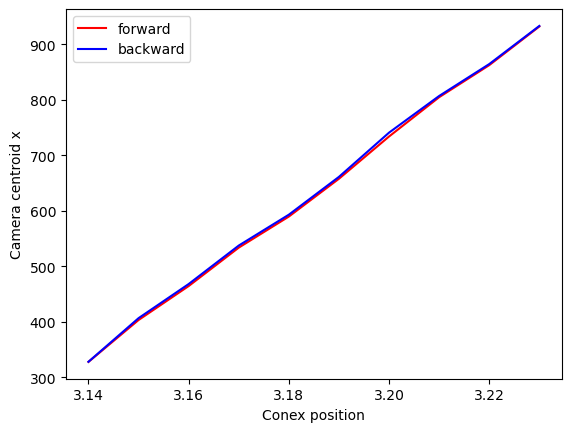

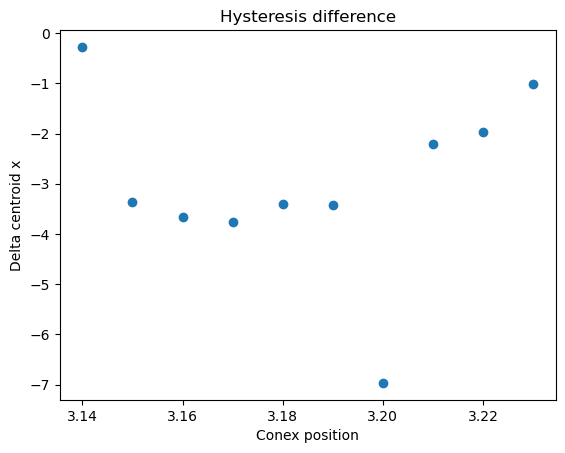

In [179]:
conex_hysteresis_test('conex1', camera1, 3.14, 3.23, 10)

In [111]:
def conex_precision_test(mcd_name, camera, pos_min, pos_max, n_points, eps):
    """
    Generate n_points random locations for the Conex to move to and
    record the difference between the actual conex position
    and the target conex position

    Also looks at the position on the camera

    Difference in points must be greater than eps
    """
    targets = np.zeros(n_points)
    targets[0] = random.random() * (pos_max - pos_min) + pos_min
    for i in range(n_points - 1):
        new_target = random.random() * (pos_max - pos_min) + pos_min
        while abs(new_target - targets[i]) <= eps:
            new_target = random.random() * (pos_max - pos_min) + pos_min
        targets[i+1] = new_target

    conex = mcd_dict[mcd_name]
    camera_x = np.zeros(n_points)
    actual_x = np.zeros(n_points)
    for i, t in enumerate(targets):
        conex_move_hysteresis(mcd_name, t, CONEX_HYSTERESIS_SIZE)
        centroids = []
        for j in range(5):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        camera_x[i] = np.mean(np.array(centroids))
        actual_x[i] = conex['device'].state[conex['alias']]
    
    with open('./calibration/conex-pp-random.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(targets, actual_x, camera_x):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")
        
    plt.scatter(targets, actual_x)
    plt.xlabel("Target position")
    plt.ylabel("Actual position")
    plt.savefig("conex_precision.png")
    plt.show()

    plt.scatter(targets, actual_x - targets)
    plt.xlabel("Target position")
    plt.ylabel("Residual")
    plt.savefig("conex_precision_residual.png")
    plt.show()

    slope, intercept, _, _, _ = stats.linregress(targets, camera_x)
    fit_x = np.linspace(pos_min, pos_max, 1000)
    fit_y = slope * fit_x + intercept

    plt.scatter(targets, camera_x)
    plt.plot(fit_x, fit_y)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_calibration.png")
    plt.show()

    residuals = camera_x - (targets * slope + intercept)
    plt.scatter(targets, residuals)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_calibration_residuals.png")
    plt.show()


In [117]:
def conex_repeatability_test(mcd_name, camera, position, n_points, x_range, eps):
    """
    Generate n_points random locations for the Conex to move to and
    record the difference between the actual conex position
    and the target conex position

    Also looks at the position on the camera

    Difference in points must be greater than eps
    """
    targets = np.zeros(n_points)
    for i in range(n_points):
        new_target = (-0.5 + random.random()) * x_range + position
        while abs(new_target - position) < eps:
            new_target = (-0.5 + random.random()) * x_range + position
        targets[i] = new_target

    conex = mcd_dict[mcd_name]
    camera_x = np.zeros(n_points)
    actual_x = np.zeros(n_points)
    for i, t in enumerate(targets):
        conex_move_hysteresis(mcd_name, t, CONEX_HYSTERESIS_SIZE)
        conex_move_hysteresis(mcd_name, position, CONEX_HYSTERESIS_SIZE)
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        camera_x[i] = np.mean(np.array(centroids))
        actual_x[i] = conex['device'].state[conex['alias']]
    
    with open('./calibration/conex-pp-repeatability.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(targets, actual_x, camera_x):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")
        
    plt.scatter(targets, actual_x)
    plt.xlabel("Target position")
    plt.ylabel("Actual position")
    plt.savefig("conex_repeatability.png")
    plt.show()

    plt.scatter(targets, actual_x - position)
    plt.xlabel("Target position")
    plt.ylabel("Residual")
    plt.savefig("conex_repeatability_residuals.png")
    plt.show()

    plt.scatter(targets, camera_x)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_repeatability_camera.png")
    plt.show()



3.17996
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
3.135411
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
moved forward
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
moved backwards
3.17996
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
3.170534
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
3.1520

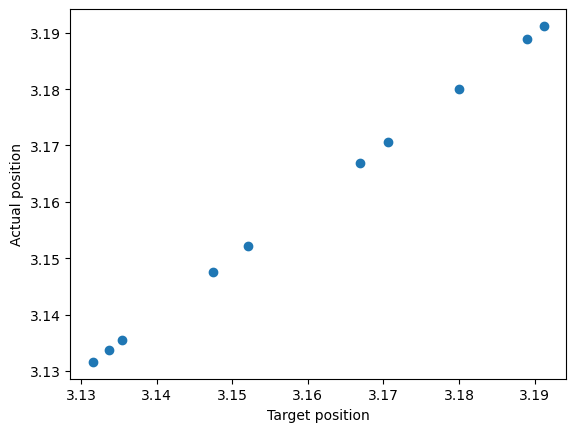

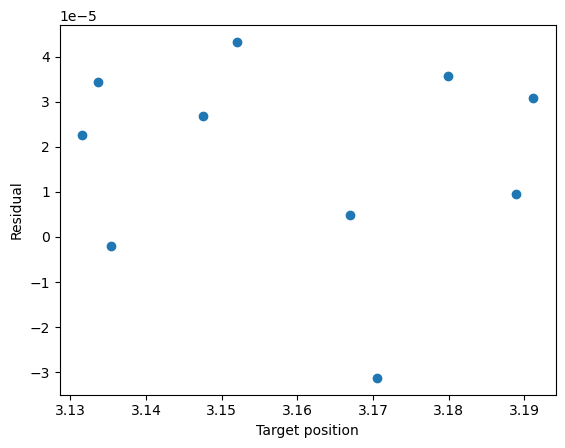

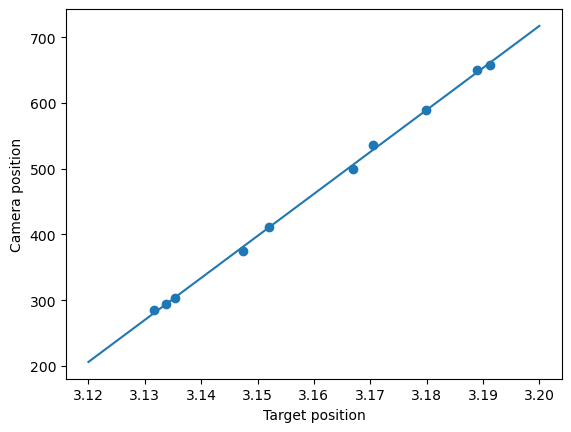

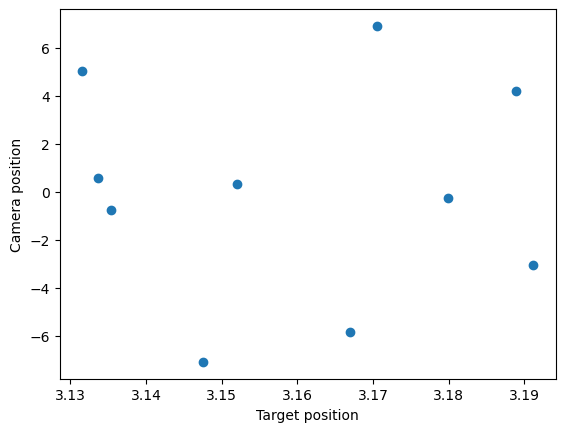

Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"
Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"
Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"
Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"
Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"
Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"

Error:
	Message: Failed to read TCP header bytes
	Source:  TcpSubscriber class, method "async_listener"


In [119]:
conex_precision_test('conex1', camera1, 3.12, 3.2, 10, 0.002)

3.18001
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
3.145035
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
moved forward
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
moved backwards
3.18001
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
3.175049
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
moved 

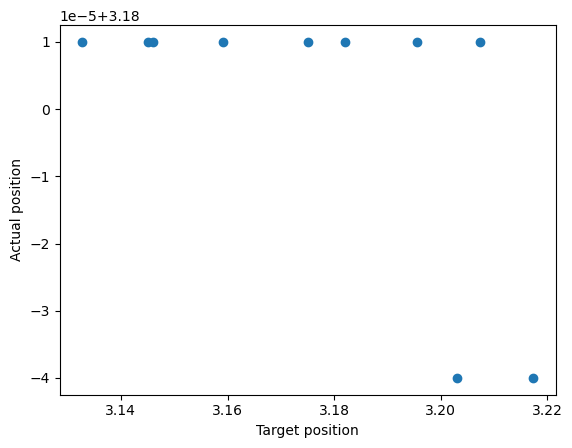

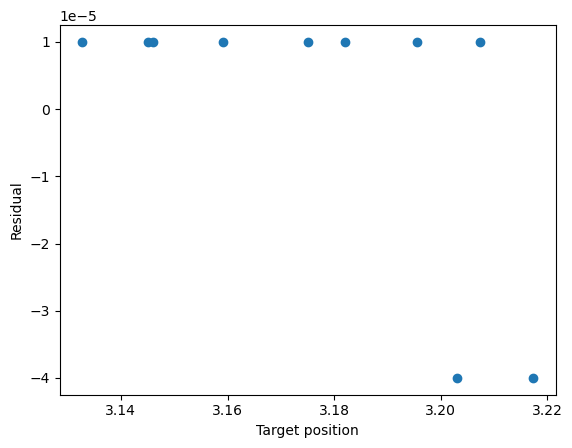

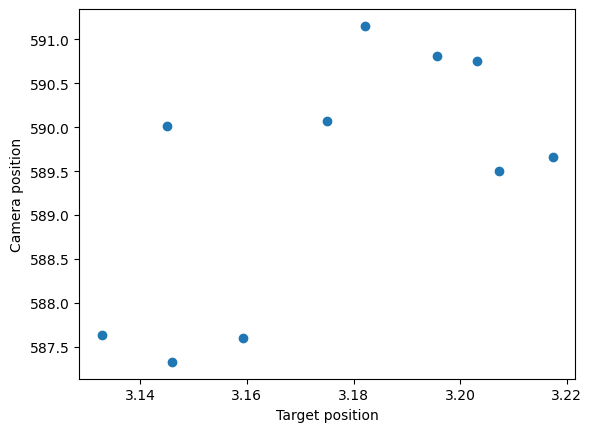

In [118]:
conex_repeatability_test('conex1', camera1, 3.18, 10, 0.1, 0.002)